In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns

#import pydicom
import time
import gc
import operator 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\skimage\__init__.py:71: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\kiner\\Anaconda3\\envs\\yuvals\\lib\\site-packages\\pytest.py' mode='r' encoding='utf-8'>
  imp.find_module('pytest')
C:\Users\kiner\Anaconda3\envs\yuvals\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\kiner\Anaconda3\envs\yuvals\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 8153
#device=device_by_name("Tesla")
device=device_by_name("1060")
torch.cuda.set_device(device)
#device = "cpu"
sendmeemail=Email_Progress(my_gmail,my_pass,to_email,'Densenet161-Copy2-2 results')

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
def get_submission_ids(image_ids,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [5]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.shape
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df=train_df.drop_duplicates().reset_index(drop=True)
train_df.shape
train_df.head()

(674510, 15)

(674252, 15)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))


In [6]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [7]:
split_sid = train_df.PID.unique()
splits=list(KFold(n_splits=3,shuffle=True, random_state=SEED).split(split_sid))


In [8]:
def my_loss(y_pred,y_true,weights):
    window=(y_true>=0).to(torch.float)
    loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*weights.expand_as(y_true)).mean()
    return loss

In [9]:
class Metric():
    def __init__(self,weights,k=0.03):
        self.weights=weights
        self.k=k
        self.zero()
        
    def zero(self):
        self.loss_sum=0.
        self.loss_count=0.
        self.lossf=0.
        
    def calc(self,y_pred,y_true,prefix=""):
        window=(y_true>=0).to(torch.float)
        loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*self.weights.expand_as(y_true)).mean()/(window.mean()+1e-5)
        self.lossf=self.lossf*(1-self.k)+loss*self.k
        self.loss_sum=self.loss_sum+loss*window.sum()
        self.loss_count=self.loss_count+window.sum()
        return({prefix+'mloss':self.lossf})    
        
    def calc_sums(self,prefix=""):
        return({prefix+'mloss_tot':self.loss_sum/self.loss_count})    



In [10]:
#features=(features-features.mean())/features.std()

In [11]:
class SimpleModel(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (7,in_size), padding=(3,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 5, padding=2)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 3, padding=1)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [12]:
class SimpleModel2(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel2, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [32]:
class ClassModel(nn.Module):
    def __init__(self,in_size):
        super(ClassModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(128, 6, 3, padding=1)
        
        self.conv2d1class=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0class=torch.nn.BatchNorm1d(128)
        self.maxpool1class=torch.nn.MaxPool1d(3)
        self.conv1d1class=torch.nn.Conv1d(128, 128, 3, padding=1)
        self.bn1class=torch.nn.BatchNorm1d(128)
        self.maxpool2class=torch.nn.MaxPool1d(3)
        self.conv1d2class=torch.nn.Conv1d(128, 64, 2, padding=1)
        self.bn2class=torch.nn.BatchNorm1d(64)

        
        
    def forward(self, x):
        z=x
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        z=self.conv2d1class(z.unsqueeze(1)).squeeze(-1)
        z=self.bn0class(z)
        z=self.maxpool1class(z)
        z=self.conv1d1class(z)
        z=self.maxpool2class(z)
        z=self.conv1d2class(z)
        z=self.bn2class(z)
        z=F.max_pool1d(z,kernel_size=z.shape[-1])
        z=z.expand_as(x)
        x=torch.cat([x,z],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [13]:
class ResModel(nn.Module):
    def __init__(self,in_size):
        super(ResModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [17]:
class ResModelIN(nn.Module):
    def __init__(self,in_size):
        super(ResModelIN, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.InstanceNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.InstanceNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.InstanceNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [15]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (5,2208), padding=(2,0))
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 6, 1)

        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.relu0(x)
        out = self.conv1d1(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


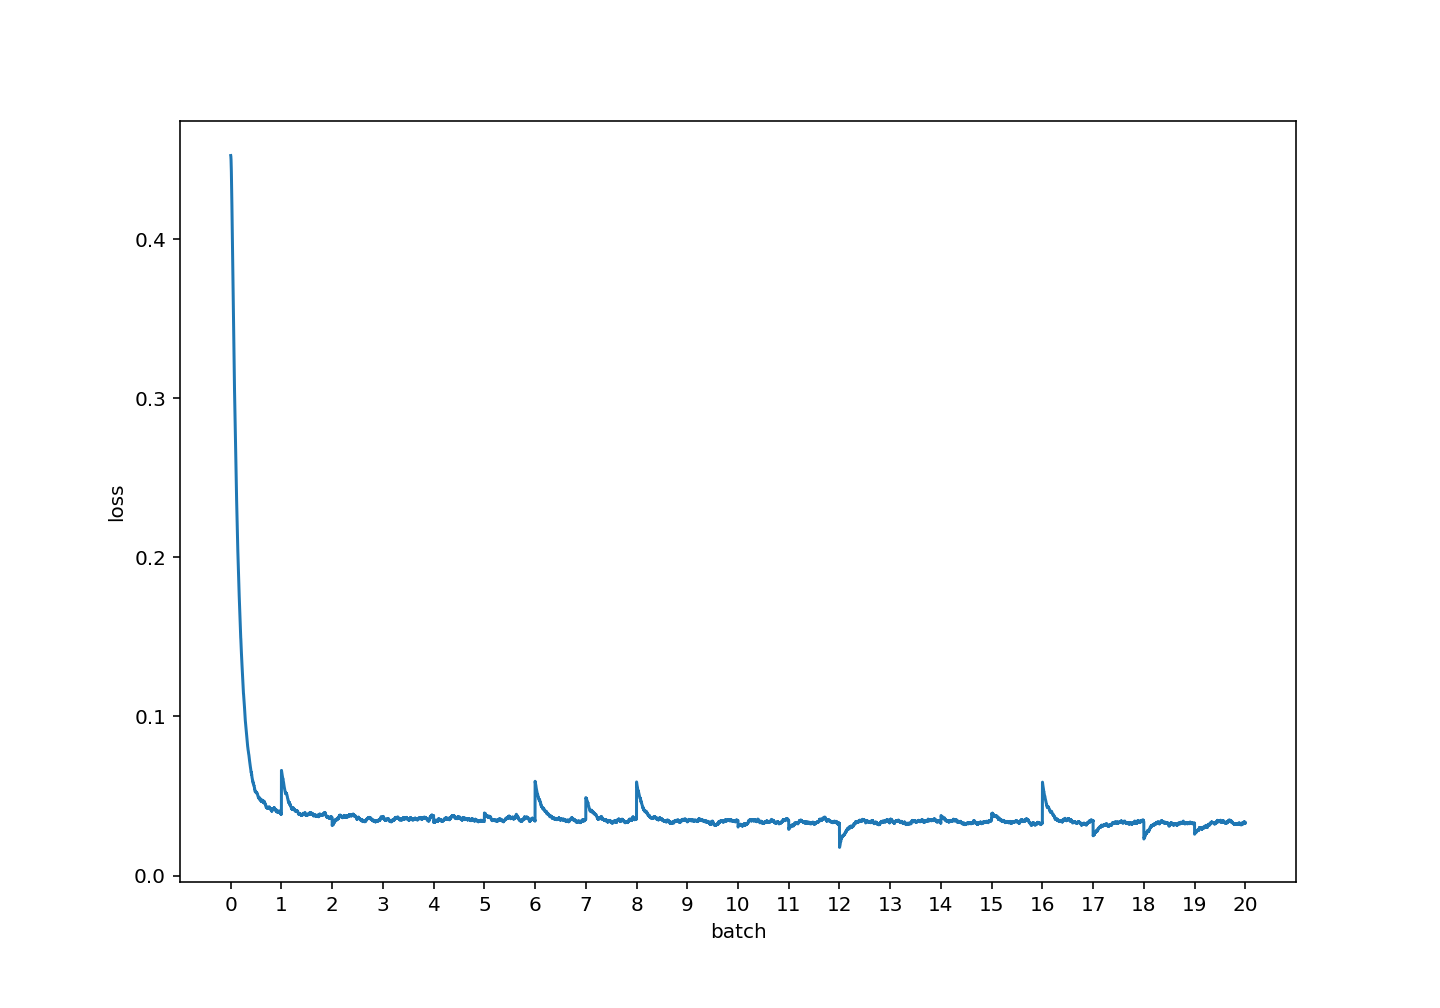

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03857258555161954, 'mloss': tensor(0.0634), 'val_loss': 0.04421147736353717, 'val_mloss_tot': tensor(0.0766)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03632886949981057, 'mloss': tensor(0.0626), 'val_loss': 0.043680387814047525, 'val_mloss_tot': tensor(0.0757)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03585366673471871, 'mloss': tensor(0.0624), 'val_loss': 0.04225964127842502, 'val_mloss_tot': tensor(0.0733)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03770133807882499, 'mloss': tensor(0.0679), 'val_loss': 0.042346621481609975, 'val_mloss_tot': tensor(0.0734)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.0342067180215674, 'mloss': tensor(0.0594), 'val_loss': 0.04178622275765233, 'val_mloss_tot': tensor(0.0724)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03429471157715925, 'mloss': tensor(0.0567), 'val_loss': 0.04216194775969414, 'val_mloss_tot': tensor(0.0731)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03543117864343762, 'mloss': tensor(0.0644), 'val_loss': 0.041726999201587046, 'val_mloss_tot': tensor(0.0723)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03587777065045621, 'mloss': tensor(0.0631), 'val_loss': 0.04199893654810421, 'val_mloss_tot': tensor(0.0728)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.034390293520167134, 'mloss': tensor(0.0587), 'val_loss': 0.043042421776782996, 'val_mloss_tot': tensor(0.0746)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03448136517167176, 'mloss': tensor(0.0600), 'val_loss': 0.041815001870794545, 'val_mloss_tot': tensor(0.0725)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03453750680285289, 'mloss': tensor(0.0580), 'val_loss': 0.041337243157434346, 'val_mloss_tot': tensor(0.0717)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.032654494448838785, 'mloss': tensor(0.0559), 'val_loss': 0.04216592052602783, 'val_mloss_tot': tensor(0.0731)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.033571132084265015, 'mloss': tensor(0.0567), 'val_loss': 0.041602573098312015, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03290669536802543, 'mloss': tensor(0.0544), 'val_loss': 0.04169351103935813, 'val_mloss_tot': tensor(0.0723)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03549090997623371, 'mloss': tensor(0.0660), 'val_loss': 0.04111730227054193, 'val_mloss_tot': tensor(0.0713)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03290462401955023, 'mloss': tensor(0.0580), 'val_loss': 0.041440980143046806, 'val_mloss_tot': tensor(0.0718)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03447942705553013, 'mloss': tensor(0.0612), 'val_loss': 0.04138617733094309, 'val_mloss_tot': tensor(0.0718)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03371394631953834, 'mloss': tensor(0.0566), 'val_loss': 0.04158383206202846, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.032722188282078825, 'mloss': tensor(0.0565), 'val_loss': 0.04165323088725506, 'val_mloss_tot': tensor(0.0722)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03312694356615847, 'mloss': tensor(0.0584), 'val_loss': 0.0420494872005427, 'val_mloss_tot': tensor(0.0729)}

0.04111730227054193


In [16]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=4
num_epochs=20

weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


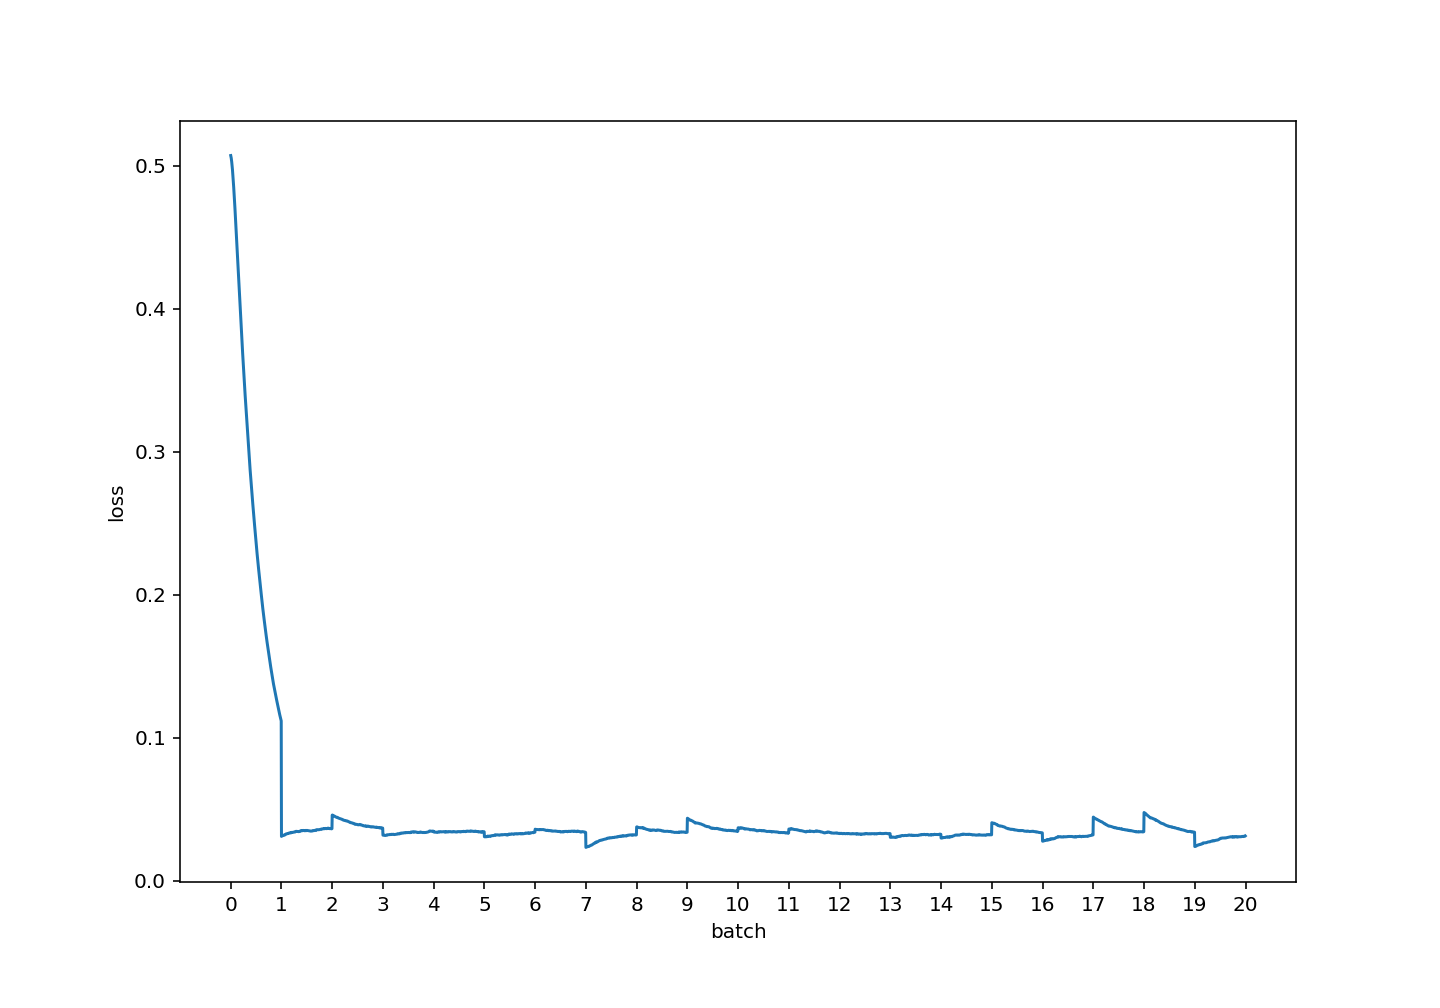

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.11180639891752658, 'mloss': tensor(0.0724), 'val_loss': 0.04584537755113607, 'val_mloss_tot': tensor(0.0797)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03650193724392013, 'mloss': tensor(0.0644), 'val_loss': 0.04453149233378616, 'val_mloss_tot': tensor(0.0774)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.036883248638572806, 'mloss': tensor(0.0612), 'val_loss': 0.04382067267764725, 'val_mloss_tot': tensor(0.0762)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03468590213002641, 'mloss': tensor(0.0617), 'val_loss': 0.04368268260184456, 'val_mloss_tot': tensor(0.0760)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03423067962101351, 'mloss': tensor(0.0587), 'val_loss': 0.04446240289903739, 'val_mloss_tot': tensor(0.0773)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03400856183337876, 'mloss': tensor(0.0613), 'val_loss': 0.043182946750711576, 'val_mloss_tot': tensor(0.0751)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.033830673995881196, 'mloss': tensor(0.0567), 'val_loss': 0.044782470875218805, 'val_mloss_tot': tensor(0.0779)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03210508545923209, 'mloss': tensor(0.0573), 'val_loss': 0.042844679042258686, 'val_mloss_tot': tensor(0.0745)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03395782150176068, 'mloss': tensor(0.0581), 'val_loss': 0.04347450880552916, 'val_mloss_tot': tensor(0.0756)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.034833874162450554, 'mloss': tensor(0.0586), 'val_loss': 0.04379020000387933, 'val_mloss_tot': tensor(0.0762)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03345365244389016, 'mloss': tensor(0.0565), 'val_loss': 0.043183653241059945, 'val_mloss_tot': tensor(0.0751)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03305533430000302, 'mloss': tensor(0.0553), 'val_loss': 0.04335028325737107, 'val_mloss_tot': tensor(0.0754)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03302180851422681, 'mloss': tensor(0.0573), 'val_loss': 0.044545707895475274, 'val_mloss_tot': tensor(0.0775)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03255600070700864, 'mloss': tensor(0.0574), 'val_loss': 0.04353527496477552, 'val_mloss_tot': tensor(0.0757)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03219774548835663, 'mloss': tensor(0.0561), 'val_loss': 0.04327184080566261, 'val_mloss_tot': tensor(0.0752)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03354453371566557, 'mloss': tensor(0.0557), 'val_loss': 0.043694515849518424, 'val_mloss_tot': tensor(0.0760)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03213432203088341, 'mloss': tensor(0.0587), 'val_loss': 0.043442213186519404, 'val_mloss_tot': tensor(0.0755)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.034382853601116294, 'mloss': tensor(0.0582), 'val_loss': 0.04359115269400325, 'val_mloss_tot': tensor(0.0758)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03406031996517682, 'mloss': tensor(0.0553), 'val_loss': 0.043379470651202345, 'val_mloss_tot': tensor(0.0754)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.031369821335603815, 'mloss': tensor(0.0566), 'val_loss': 0.04327070375210514, 'val_mloss_tot': tensor(0.0752)}

0.042844679042258686


In [15]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=64
num_workers=4
num_epochs=20

weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


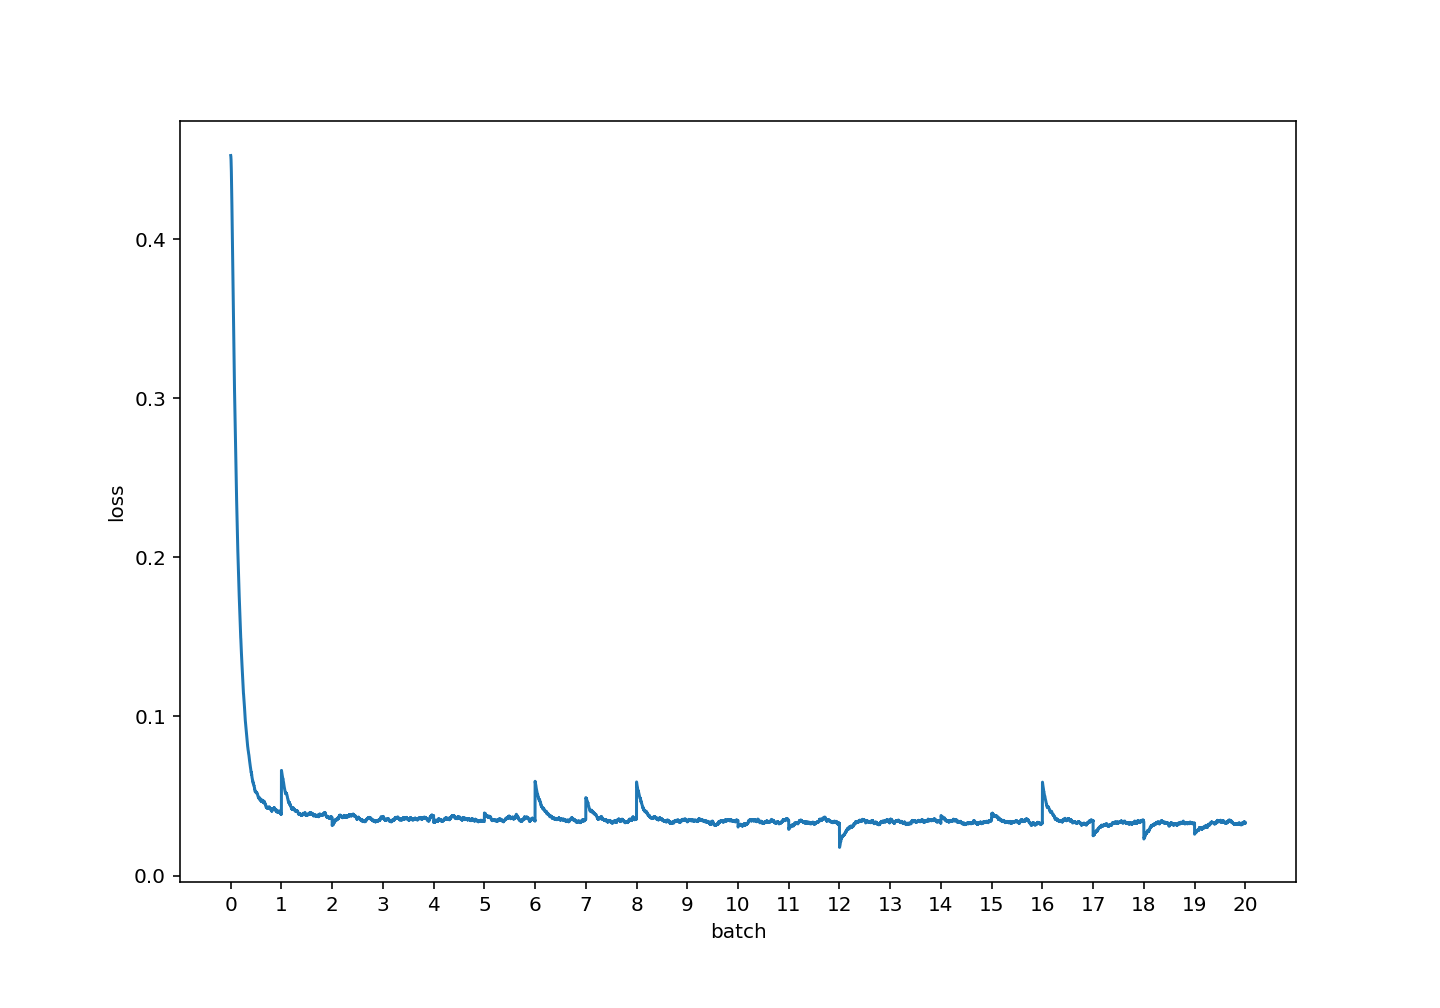

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03857258555161954, 'mloss': tensor(0.0634), 'val_loss': 0.04421147736353717, 'val_mloss_tot': tensor(0.0766)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03632886949981057, 'mloss': tensor(0.0626), 'val_loss': 0.043680387814047525, 'val_mloss_tot': tensor(0.0757)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03585366673471871, 'mloss': tensor(0.0624), 'val_loss': 0.04225964127842502, 'val_mloss_tot': tensor(0.0733)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03770133807882499, 'mloss': tensor(0.0679), 'val_loss': 0.042346621481609975, 'val_mloss_tot': tensor(0.0734)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.0342067180215674, 'mloss': tensor(0.0594), 'val_loss': 0.04178622275765233, 'val_mloss_tot': tensor(0.0724)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03429471157715925, 'mloss': tensor(0.0567), 'val_loss': 0.04216194775969414, 'val_mloss_tot': tensor(0.0731)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03543117864343762, 'mloss': tensor(0.0644), 'val_loss': 0.041726999201587046, 'val_mloss_tot': tensor(0.0723)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03587777065045621, 'mloss': tensor(0.0631), 'val_loss': 0.04199893654810421, 'val_mloss_tot': tensor(0.0728)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.034390293520167134, 'mloss': tensor(0.0587), 'val_loss': 0.043042421776782996, 'val_mloss_tot': tensor(0.0746)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03448136517167176, 'mloss': tensor(0.0600), 'val_loss': 0.041815001870794545, 'val_mloss_tot': tensor(0.0725)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03453750680285289, 'mloss': tensor(0.0580), 'val_loss': 0.041337243157434346, 'val_mloss_tot': tensor(0.0717)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.032654494448838785, 'mloss': tensor(0.0559), 'val_loss': 0.04216592052602783, 'val_mloss_tot': tensor(0.0731)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.033571132084265015, 'mloss': tensor(0.0567), 'val_loss': 0.041602573098312015, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03290669536802543, 'mloss': tensor(0.0544), 'val_loss': 0.04169351103935813, 'val_mloss_tot': tensor(0.0723)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03549090997623371, 'mloss': tensor(0.0660), 'val_loss': 0.04111730227054193, 'val_mloss_tot': tensor(0.0713)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03290462401955023, 'mloss': tensor(0.0580), 'val_loss': 0.041440980143046806, 'val_mloss_tot': tensor(0.0718)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03447942705553013, 'mloss': tensor(0.0612), 'val_loss': 0.04138617733094309, 'val_mloss_tot': tensor(0.0718)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03371394631953834, 'mloss': tensor(0.0566), 'val_loss': 0.04158383206202846, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.032722188282078825, 'mloss': tensor(0.0565), 'val_loss': 0.04165323088725506, 'val_mloss_tot': tensor(0.0722)}


HBox(children=(IntProgress(value=0, max=815), HTML(value='')))

HBox(children=(IntProgress(value=0, max=406), HTML(value='')))

{'loss': 0.03312694356615847, 'mloss': tensor(0.0584), 'val_loss': 0.0420494872005427, 'val_mloss_tot': tensor(0.0729)}

0.04111730227054193


In [16]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=4
num_epochs=20

weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


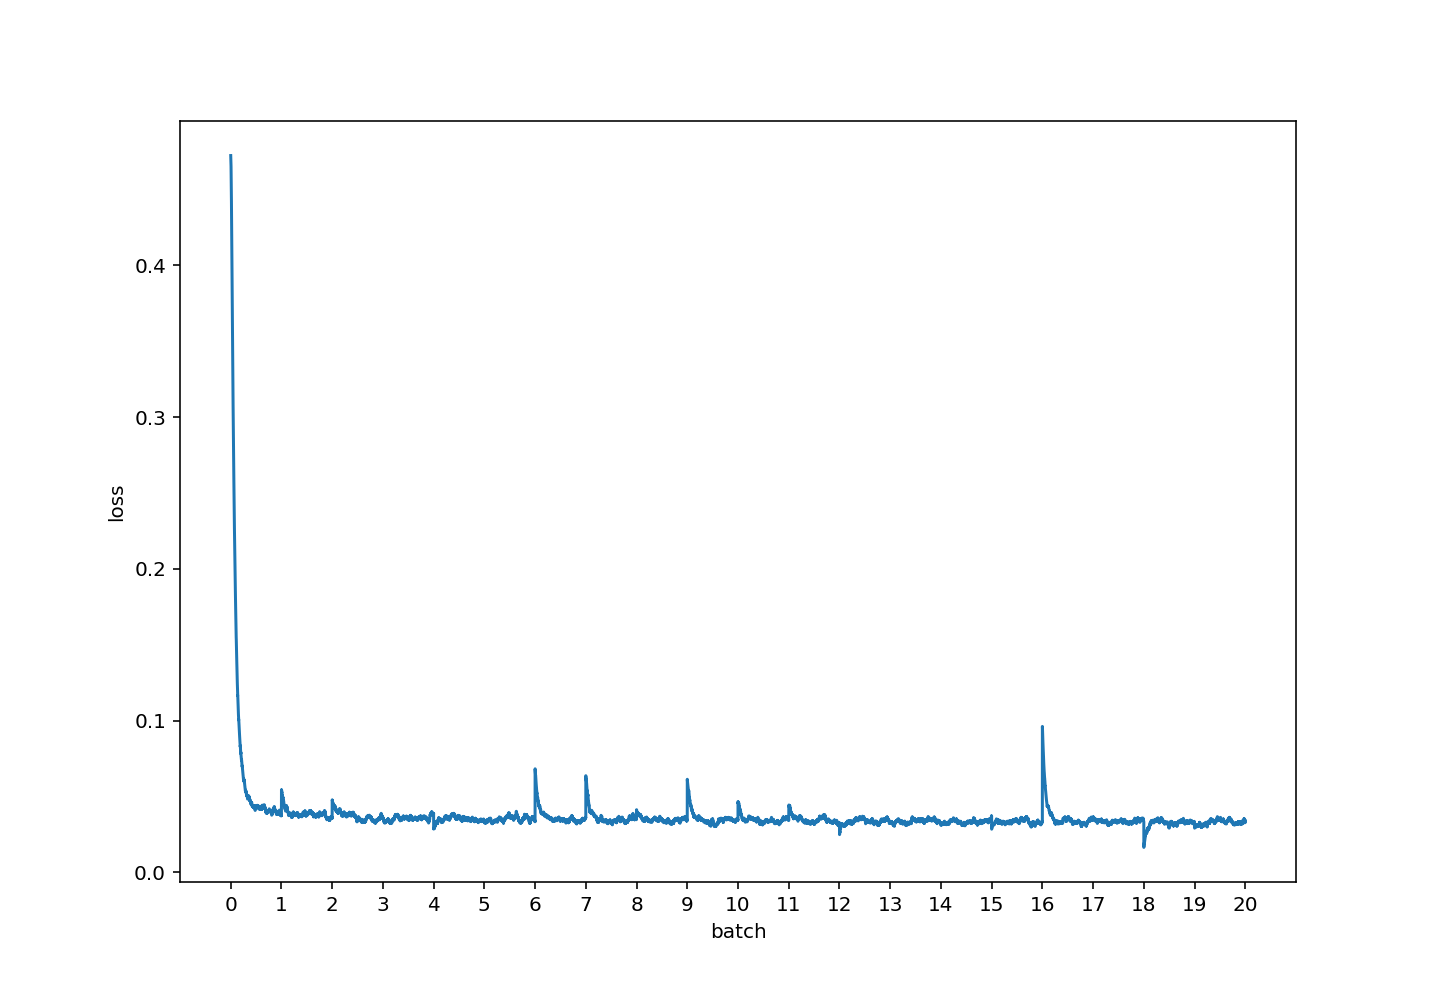

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03736557507806947, 'mloss': tensor(0.0619), 'val_loss': 0.043492997843534754, 'val_mloss_tot': tensor(0.0754)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.035792786188542876, 'mloss': tensor(0.0624), 'val_loss': 0.04372200151527498, 'val_mloss_tot': tensor(0.0758)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03572855577285513, 'mloss': tensor(0.0591), 'val_loss': 0.0426361711536006, 'val_mloss_tot': tensor(0.0739)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03885046187200285, 'mloss': tensor(0.0691), 'val_loss': 0.042106324380861246, 'val_mloss_tot': tensor(0.0730)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03438624493235365, 'mloss': tensor(0.0603), 'val_loss': 0.04215844124876734, 'val_mloss_tot': tensor(0.0731)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03341654896694299, 'mloss': tensor(0.0538), 'val_loss': 0.042109403388382316, 'val_mloss_tot': tensor(0.0730)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03624512192996653, 'mloss': tensor(0.0662), 'val_loss': 0.04178911019942443, 'val_mloss_tot': tensor(0.0724)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.0358372840499032, 'mloss': tensor(0.0628), 'val_loss': 0.041419573009944304, 'val_mloss_tot': tensor(0.0718)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.0343373274872342, 'mloss': tensor(0.0590), 'val_loss': 0.04294865032967084, 'val_mloss_tot': tensor(0.0745)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03438771599906533, 'mloss': tensor(0.0592), 'val_loss': 0.04165482376878473, 'val_mloss_tot': tensor(0.0722)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03411618619155345, 'mloss': tensor(0.0551), 'val_loss': 0.041464208928338284, 'val_mloss_tot': tensor(0.0719)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03221655515221773, 'mloss': tensor(0.0565), 'val_loss': 0.041567431386436045, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03330957672205728, 'mloss': tensor(0.0569), 'val_loss': 0.04124364855279458, 'val_mloss_tot': tensor(0.0715)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03171360731397632, 'mloss': tensor(0.0514), 'val_loss': 0.0422081084549341, 'val_mloss_tot': tensor(0.0732)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03696253124215813, 'mloss': tensor(0.0711), 'val_loss': 0.04079015321356905, 'val_mloss_tot': tensor(0.0707)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.033266639272356076, 'mloss': tensor(0.0600), 'val_loss': 0.041195519257401655, 'val_mloss_tot': tensor(0.0714)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03474161761587246, 'mloss': tensor(0.0601), 'val_loss': 0.04151669246762655, 'val_mloss_tot': tensor(0.0720)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03320892901676931, 'mloss': tensor(0.0527), 'val_loss': 0.041588019492050744, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03279468548242849, 'mloss': tensor(0.0570), 'val_loss': 0.04163031654928185, 'val_mloss_tot': tensor(0.0722)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03392211889286847, 'mloss': tensor(0.0601), 'val_loss': 0.04193822231169233, 'val_mloss_tot': tensor(0.0727)}
0.04079015321356905


In [20]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=8
num_workers=4
num_epochs=20

weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.00025)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


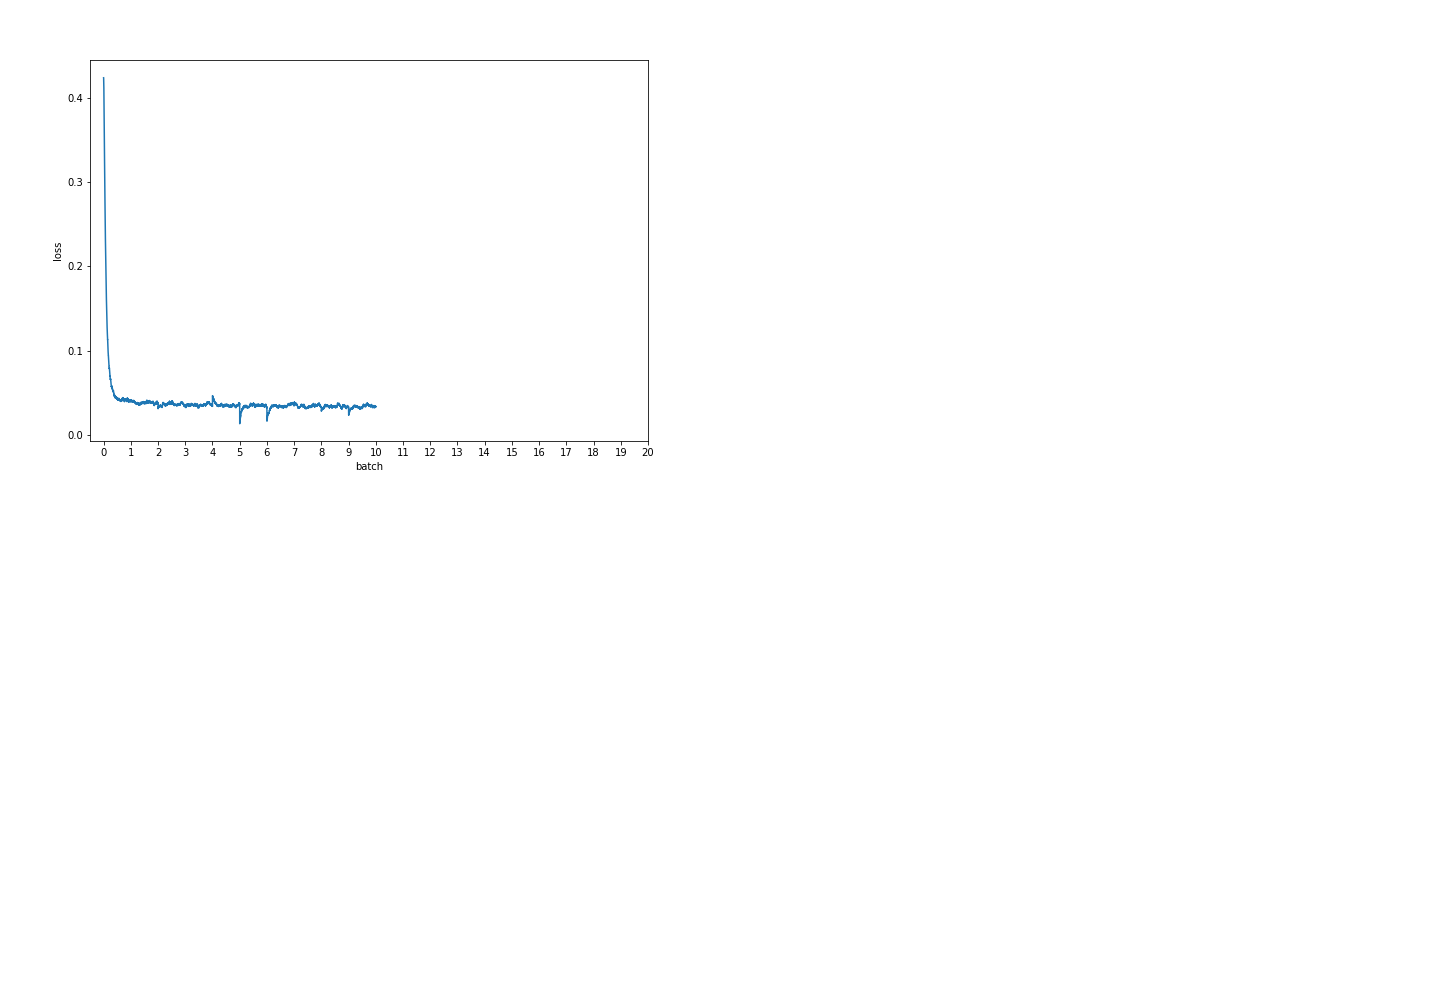

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.040943758357681735, 'mloss': tensor(0.0724), 'val_loss': 0.043485106574672534, 'val_mloss_tot': tensor(0.0754)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.037712172179988915, 'mloss': tensor(0.0628), 'val_loss': 0.04240614683439713, 'val_mloss_tot': tensor(0.0735)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03619279850601382, 'mloss': tensor(0.0668), 'val_loss': 0.042302516952421966, 'val_mloss_tot': tensor(0.0733)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03444535603874589, 'mloss': tensor(0.0564), 'val_loss': 0.04271636630907102, 'val_mloss_tot': tensor(0.0741)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03703693742752571, 'mloss': tensor(0.0641), 'val_loss': 0.04249244599572723, 'val_mloss_tot': tensor(0.0737)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.033761457175067115, 'mloss': tensor(0.0593), 'val_loss': 0.042046770365496415, 'val_mloss_tot': tensor(0.0729)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.03540284549593256, 'mloss': tensor(0.0594), 'val_loss': 0.042078771969405855, 'val_mloss_tot': tensor(0.0730)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.033782250326441554, 'mloss': tensor(0.0574), 'val_loss': 0.04171916316939361, 'val_mloss_tot': tensor(0.0723)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

{'loss': 0.033654575614059136, 'mloss': tensor(0.0585), 'val_loss': 0.04144434481710104, 'val_mloss_tot': tensor(0.0719)}


HBox(children=(IntProgress(value=0, max=1630), HTML(value='')))

HBox(children=(IntProgress(value=0, max=812), HTML(value='')))

In [ ]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=8
num_workers=4
num_epochs=20

weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ClassModel(features.shape[-1])
version=version+'_fullhead_classModel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.00025)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


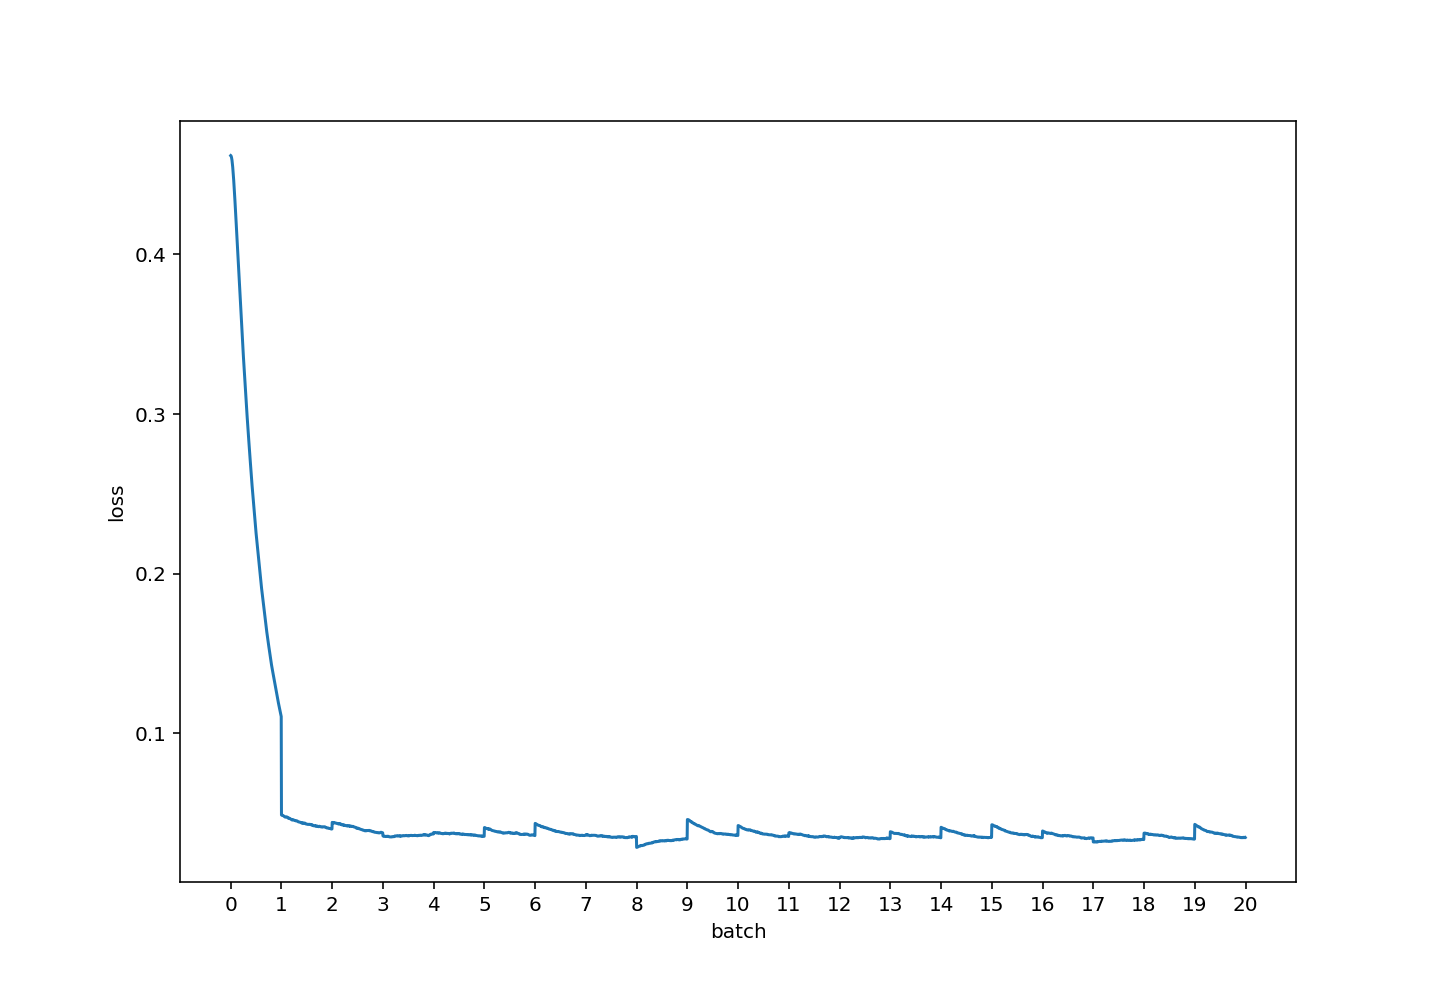

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.11046379332564168, 'mloss': tensor(0.0772), 'val_loss': 0.04598852942752488, 'val_mloss_tot': tensor(0.0796)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03999509653286545, 'mloss': tensor(0.0657), 'val_loss': 0.04532857502208037, 'val_mloss_tot': tensor(0.0785)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.0375758256839677, 'mloss': tensor(0.0626), 'val_loss': 0.04274309373588538, 'val_mloss_tot': tensor(0.0740)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03688856726080426, 'mloss': tensor(0.0662), 'val_loss': 0.042492979589630574, 'val_mloss_tot': tensor(0.0736)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.035405187292510326, 'mloss': tensor(0.0598), 'val_loss': 0.04213943389043504, 'val_mloss_tot': tensor(0.0730)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03584952752129089, 'mloss': tensor(0.0600), 'val_loss': 0.043066052610383314, 'val_mloss_tot': tensor(0.0746)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03606197554988577, 'mloss': tensor(0.0614), 'val_loss': 0.04174414074377102, 'val_mloss_tot': tensor(0.0723)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.035314513058459195, 'mloss': tensor(0.0622), 'val_loss': 0.04165407275671468, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.0337145830562466, 'mloss': tensor(0.0598), 'val_loss': 0.041673195329220855, 'val_mloss_tot': tensor(0.0722)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.035938035429738883, 'mloss': tensor(0.0601), 'val_loss': 0.04240781381068861, 'val_mloss_tot': tensor(0.0734)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03531798196466991, 'mloss': tensor(0.0598), 'val_loss': 0.04155065482664926, 'val_mloss_tot': tensor(0.0720)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03429689789925073, 'mloss': tensor(0.0577), 'val_loss': 0.04238084933775313, 'val_mloss_tot': tensor(0.0734)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03399903579777197, 'mloss': tensor(0.0584), 'val_loss': 0.04167022694851838, 'val_mloss_tot': tensor(0.0722)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.0344804736180705, 'mloss': tensor(0.0582), 'val_loss': 0.041982172367473446, 'val_mloss_tot': tensor(0.0727)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.034933392937870275, 'mloss': tensor(0.0608), 'val_loss': 0.04140458374704216, 'val_mloss_tot': tensor(0.0717)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03454022813658344, 'mloss': tensor(0.0571), 'val_loss': 0.04253016015989523, 'val_mloss_tot': tensor(0.0737)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03440644353271773, 'mloss': tensor(0.0593), 'val_loss': 0.0416404775471664, 'val_mloss_tot': tensor(0.0721)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.033361381196265825, 'mloss': tensor(0.0584), 'val_loss': 0.04181931575066319, 'val_mloss_tot': tensor(0.0725)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.03369075863217017, 'mloss': tensor(0.0570), 'val_loss': 0.04231239690938417, 'val_mloss_tot': tensor(0.0733)}


HBox(children=(IntProgress(value=0, max=204), HTML(value='')))

HBox(children=(IntProgress(value=0, max=102), HTML(value='')))

{'loss': 0.034629698003588345, 'mloss': tensor(0.0582), 'val_loss': 0.04247536141352326, 'val_mloss_tot': tensor(0.0736)}

0.04140458374704216


In [15]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=64
num_workers=4
num_epochs=20

weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [17]:

model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [18]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

HBox(children=(IntProgress(value=0, max=2214), HTML(value='')))

(78545,)

(78545, 6)

In [30]:
preds2=preds

In [19]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape

features=features[np.where(~dup)]
features.shape[0]

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=4

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=SimpleModel2(features.shape[-1])
num_epochs=13
version='basic_classifier_wso_tta'+'_fullhead_SimpleModel2'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2698016, 208])

In [24]:

model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead_SimpleModel2'
model=SimpleModel2(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [25]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

HBox(children=(IntProgress(value=0, max=2214), HTML(value='')))

(78545,)

(78545, 6)

torch.Size([2698016, 208])

torch.Size([674504, 4, 208])

674252

<IPython.core.display.Javascript object>


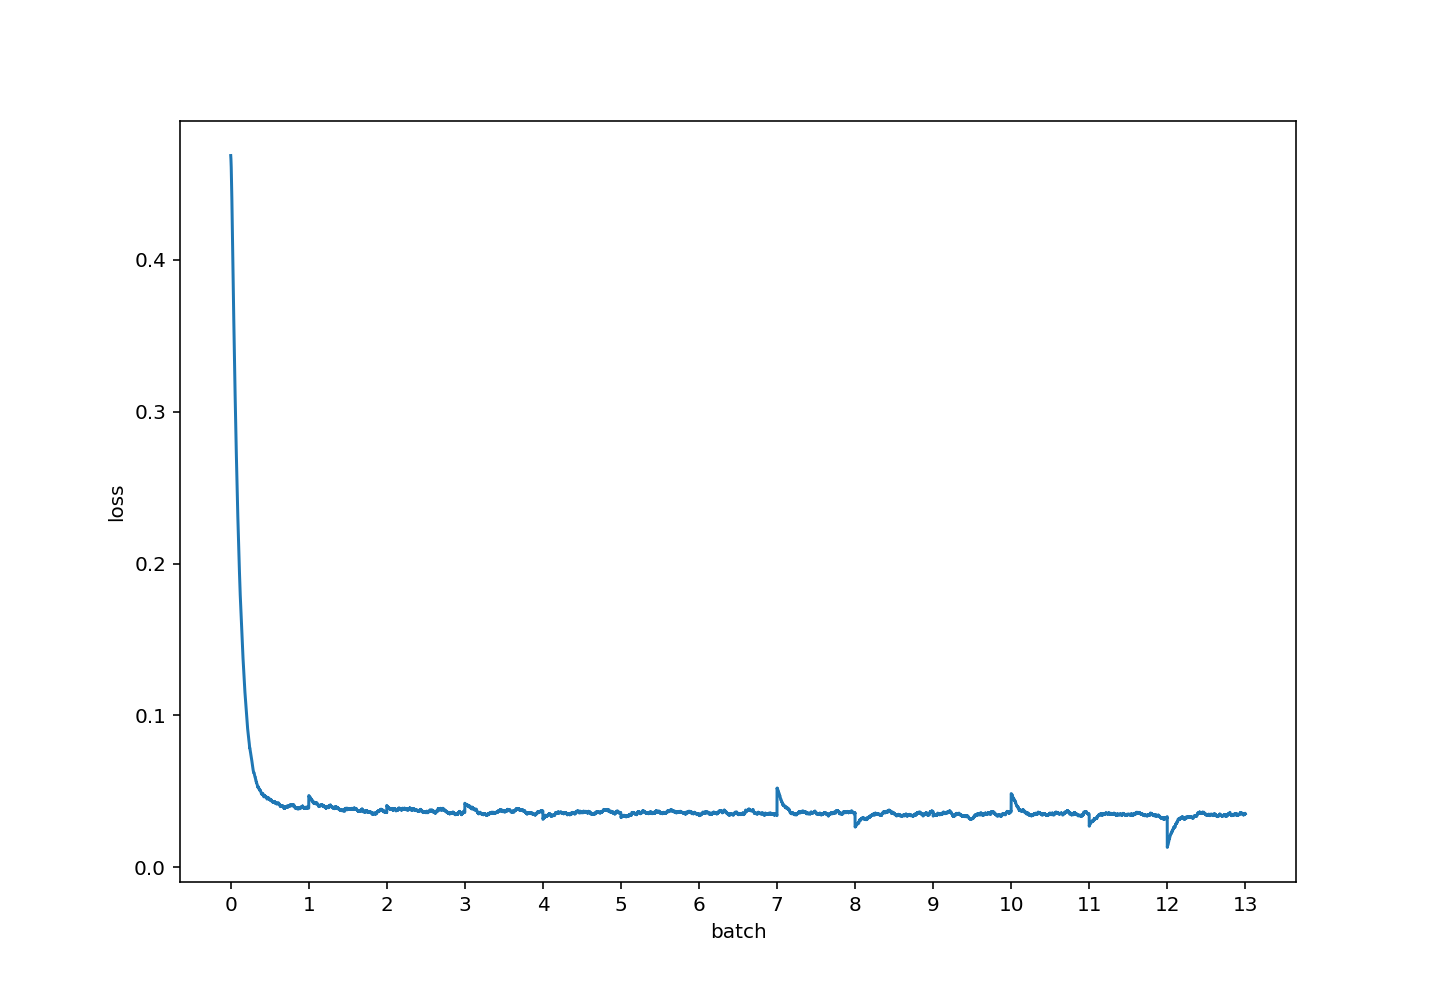

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03905289494198026, 'mloss': tensor(0.0673), 'val_loss': 0.03942327253232763, 'val_mloss_tot': tensor(0.0685)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.036056500871393275, 'mloss': tensor(0.0601), 'val_loss': 0.03856969929898415, 'val_mloss_tot': tensor(0.0672)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.036157825002352595, 'mloss': tensor(0.0627), 'val_loss': 0.03853742551527978, 'val_mloss_tot': tensor(0.0672)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.037092187134055876, 'mloss': tensor(0.0664), 'val_loss': 0.03816107109310181, 'val_mloss_tot': tensor(0.0665)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03559918814507208, 'mloss': tensor(0.0601), 'val_loss': 0.038169686584089826, 'val_mloss_tot': tensor(0.0664)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03500326493448298, 'mloss': tensor(0.0600), 'val_loss': 0.038110269865823714, 'val_mloss_tot': tensor(0.0664)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03412779539306238, 'mloss': tensor(0.0568), 'val_loss': 0.0378337625330844, 'val_mloss_tot': tensor(0.0659)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.035864238175080256, 'mloss': tensor(0.0621), 'val_loss': 0.03793144172314948, 'val_mloss_tot': tensor(0.0659)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03665815665068866, 'mloss': tensor(0.0649), 'val_loss': 0.03769904083564756, 'val_mloss_tot': tensor(0.0656)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03667261406013884, 'mloss': tensor(0.0662), 'val_loss': 0.037481916928285265, 'val_mloss_tot': tensor(0.0652)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03493664575265578, 'mloss': tensor(0.0587), 'val_loss': 0.03802414650354928, 'val_mloss_tot': tensor(0.0662)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.033157905908999745, 'mloss': tensor(0.0595), 'val_loss': 0.03852414127772417, 'val_mloss_tot': tensor(0.0670)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03531371183304948, 'mloss': tensor(0.0621), 'val_loss': 0.037744468778402096, 'val_mloss_tot': tensor(0.0657)}

0.037481916928285265


In [19]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape

features=features[np.where(~dup)]
features.shape[0]

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=2

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
num_epochs=13
version='basic_classifier_wso_tta'+'_fullhead_ResModel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [20]:

model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead_ResModel'
model=ResModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [21]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

HBox(children=(IntProgress(value=0, max=2214), HTML(value='')))

(78545,)

(78545, 6)

In [26]:
preds1=preds

In [31]:
preds=(preds1+preds2)/2

In [19]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))

submission_df.head(12)
submission_df.shape
sub_num=35
submission_df.to_csv('E:/RSNA/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])

,ID,Label
0,ID_000012eaf_any,0.002471
1,ID_000012eaf_epidural,0.000100
2,ID_000012eaf_intraparenchymal,0.000293
3,ID_000012eaf_intraventricular,0.000137
4,ID_000012eaf_subarachnoid,0.000436
5,ID_000012eaf_subdural,0.001701
6,ID_0000ca2f6_any,0.001617
7,ID_0000ca2f6_epidural,0.000053
8,ID_0000ca2f6_intraparenchymal,0.000230
9,ID_0000ca2f6_intraventricular,0.000049


(471270, 2)

In [43]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
version=version+'_fullhead'
model=SimpleModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=64)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

In [44]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds1=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

HBox(children=(IntProgress(value=0, max=2214), HTML(value='')))

In [45]:
preds0=preds


In [46]:
preds=(preds0+preds1)/2

In [47]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))
submission_df.head(12)
submission_df.shape
sub_num=28
submission_df.to_csv('E:/RSNA/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,0.004199
1,ID_000012eaf_epidural,0.000201
2,ID_000012eaf_intraparenchymal,0.000525
3,ID_000012eaf_intraventricular,0.000181
4,ID_000012eaf_subarachnoid,0.001289
5,ID_000012eaf_subdural,0.002139
6,ID_0000ca2f6_any,0.001799
7,ID_0000ca2f6_epidural,0.000060
8,ID_0000ca2f6_intraparenchymal,0.000452
9,ID_0000ca2f6_intraventricular,0.000059


(471270, 2)

<IPython.core.display.Javascript object>


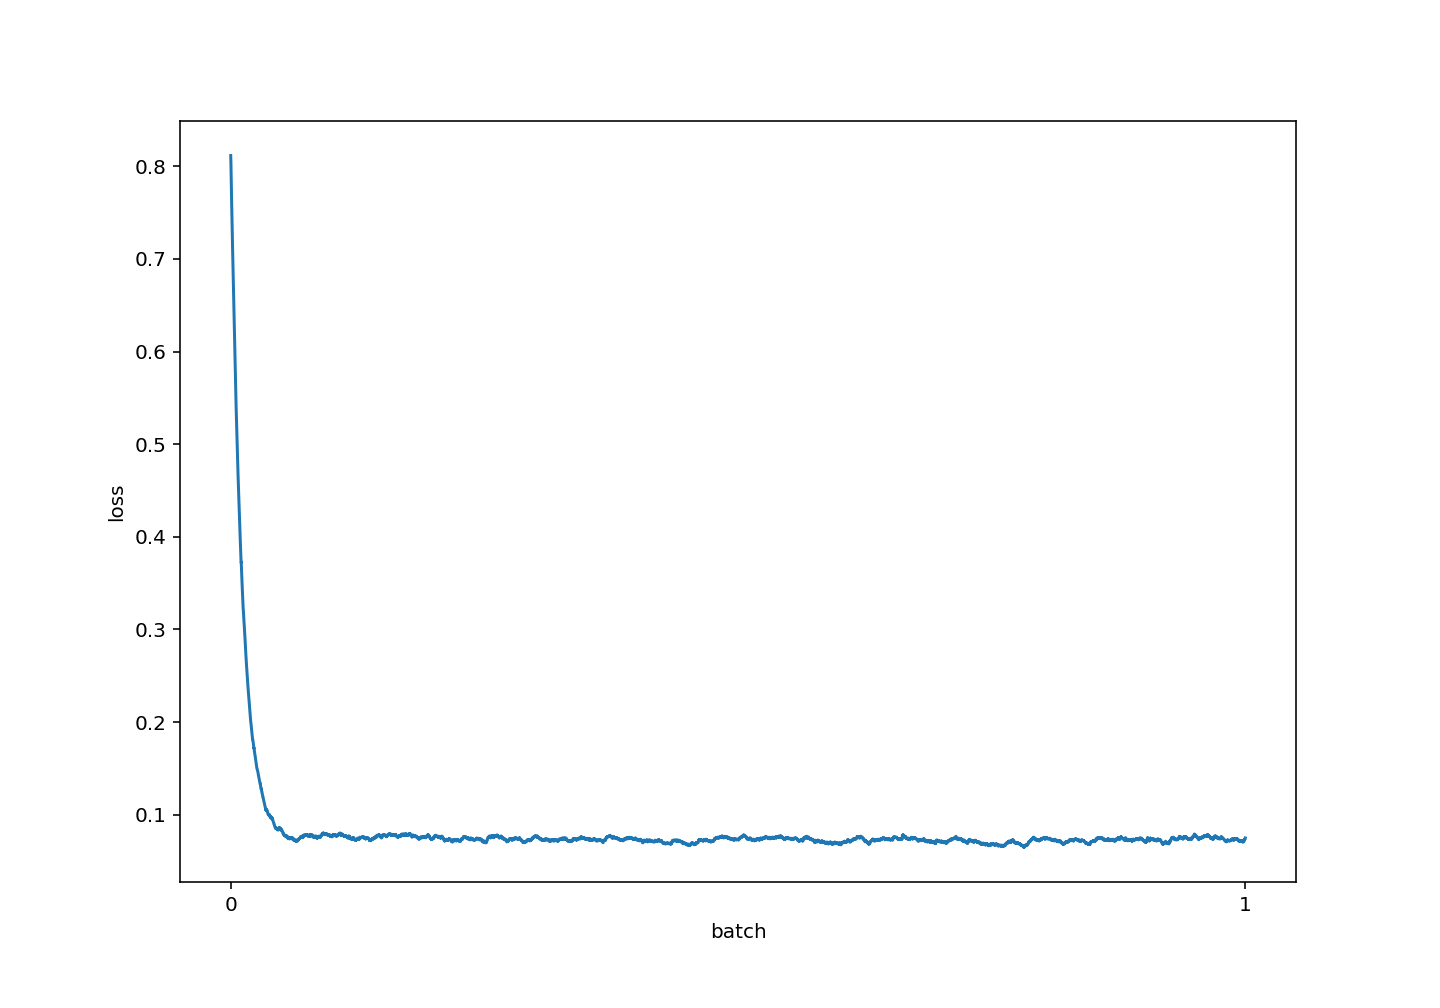

{'loss': 0.0749485937337074, 'val_loss': 0.07314836643778007}
0.07314836643778007


In [15]:
%matplotlib nbagg
num_neighbors=3
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))